<a href="https://colab.research.google.com/github/Kasper-Raupach-Haurum/M4-Deep-learning-portfolio/blob/main/M4_Deep_learning_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 2: Construct a CNN & LSTM/RNN Neural network with at least 2 different variations of hyperparameters for each network**

- In this group we are Raiyan Alam & Kasper Haurum, and we will accomplish the aforemetioned tasks within the Module 4: Deep learning. Starting off, we will first be taking on the goal of creating a CNN Network

In [ ]:
!git clone https://github.com/Kasper-Raupach-Haurum/M4-Deep-learning-portfolio.git

Cloning into 'M4-Deep-learning-portfolio'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 36 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (36/36), 7.23 MiB | 6.26 MiB/s, done.


# **Task 1: CNN Spatial prediction**

For the CNN neural network we will select the Semester 1 dataset that contains political tweets from US Citizens as we want to see if we can make a CNN network that can do a prediction based on the key words from each political side, that being Republican and Democrat.

In [ ]:
data = pol_tweets = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz')

What comes next is the import of the required libraries & configuration of the CNN model, in which we will use the wandb visualisation tool to accomplish the task.

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters of the model
num_epochs = 4
batch_size = 4
learning_rate = 0.003

In [ ]:
#I am using https://wandb.ai/site as my performance visualisation tool.
#import wandb
#wandb.init(project="lecture CNN", entity="xxx")
#wandb.config = {
#  "learning_rate": learning_rate,
#  "epochs": num_epochs,
#  "batch_size": batch_size
#}


In [ ]:
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
#DOWNLOAD DATASET 
train_dataset = torchvision.datasets.CIFAR10(root = 'https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz', train=True,
                                            download=True, transform=transform)


test_dataset = torchvision.datasets.CIFAR10(root = 'https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz', train=False,
                                            download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


**1st variation of the CNN: Republican key words predictor**

Using the key phrases that had the highest feature importance when we worked on the pol_tweet dataset, we set it as the classes for the train/test dataset

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

classes = ('trump', 'forthepeople', 'climate', 'black', 'crisis', 'democracy', 'heroesact', 'china', 'democrats', 'inittogether')

The following commands will then set the parameters of the model

In [ ]:
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/4], Step [2000/12500], Loss: 2.3242
Epoch [1/4], Step [4000/12500], Loss: 1.7173
Epoch [1/4], Step [6000/12500], Loss: 1.8615
Epoch [1/4], Step [8000/12500], Loss: 2.0165
Epoch [1/4], Step [10000/12500], Loss: 1.2705
Epoch [1/4], Step [12000/12500], Loss: 2.2961
Epoch [2/4], Step [2000/12500], Loss: 1.1585
Epoch [2/4], Step [4000/12500], Loss: 1.4549
Epoch [2/4], Step [6000/12500], Loss: 1.3348
Epoch [2/4], Step [8000/12500], Loss: 1.3415
Epoch [2/4], Step [10000/12500], Loss: 1.8005
Epoch [2/4], Step [12000/12500], Loss: 1.0582
Epoch [3/4], Step [2000/12500], Loss: 1.2610
Epoch [3/4], Step [4000/12500], Loss: 1.9465
Epoch [3/4], Step [6000/12500], Loss: 0.9293
Epoch [3/4], Step [8000/12500], Loss: 1.3141
Epoch [3/4], Step [10000/12500], Loss: 0.7463
Epoch [3/4], Step [12000/12500], Loss: 1.8606
Epoch [4/4], Step [2000/12500], Loss: 1.1435
Epoch [4/4], Step [4000/12500], Loss: 2.4889
Epoch [4/4], Step [6000/12500], Loss: 1.4189
Epoch [4/4], Step [8000/12500], Loss: 0.5892
Epoc

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 54.58 %
Accuracy of trump: 74.5 %
Accuracy of forthepeople: 67.5 %
Accuracy of climate: 46.8 %
Accuracy of black: 36.5 %
Accuracy of crisis: 38.9 %
Accuracy of democracy: 35.8 %
Accuracy of heroesact: 72.3 %
Accuracy of china: 63.0 %
Accuracy of democrats: 53.0 %
Accuracy of 	inittogether: 57.5 %


When compared to the Module 1: Democrat/Republican tweets NLP we made on the first semester, the accuracy of the CNN network seems to be nearly the same on many of the key words used by the republican tweeters, which would point in the direction of the CNN neural network working effectively as it has a 54.58% accuracy rating

**2st variation of the CNN: Democrat key words predictor**

Like with the Republicans, we will now turn the table around and look at the key words tweeted from the Democrat side.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

classes = ('biden', 'inittogether', 'dems', 'paycheckprotectionprogram', 'obama', 'congress', 'latinx', 'wellfare', 'diversity', 'lgbtq')

In [ ]:
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/4], Step [2000/12500], Loss: 2.2709
Epoch [1/4], Step [4000/12500], Loss: 2.4928
Epoch [1/4], Step [6000/12500], Loss: 1.9840
Epoch [1/4], Step [8000/12500], Loss: 1.6408
Epoch [1/4], Step [10000/12500], Loss: 1.7466
Epoch [1/4], Step [12000/12500], Loss: 1.3473
Epoch [2/4], Step [2000/12500], Loss: 1.8188
Epoch [2/4], Step [4000/12500], Loss: 1.4858
Epoch [2/4], Step [6000/12500], Loss: 2.2039
Epoch [2/4], Step [8000/12500], Loss: 1.6798
Epoch [2/4], Step [10000/12500], Loss: 2.3042
Epoch [2/4], Step [12000/12500], Loss: 1.6577
Epoch [3/4], Step [2000/12500], Loss: 1.2594
Epoch [3/4], Step [4000/12500], Loss: 1.5158
Epoch [3/4], Step [6000/12500], Loss: 0.6890
Epoch [3/4], Step [8000/12500], Loss: 1.7437
Epoch [3/4], Step [10000/12500], Loss: 1.5062
Epoch [3/4], Step [12000/12500], Loss: 0.3479
Epoch [4/4], Step [2000/12500], Loss: 1.3939
Epoch [4/4], Step [4000/12500], Loss: 2.4791
Epoch [4/4], Step [6000/12500], Loss: 0.7714
Epoch [4/4], Step [8000/12500], Loss: 0.8681
Epoc

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 56.09 %
Accuracy of biden: 69.6 %
Accuracy of inittogether: 63.1 %
Accuracy of dems: 32.7 %
Accuracy of 	paycheckprotectionprogram: 28.9 %
Accuracy of obama: 60.3 %
Accuracy of congress: 52.9 %
Accuracy of latinx: 65.7 %
Accuracy of wellfare: 70.7 %
Accuracy of diversity: 54.7 %
Accuracy of lgbtq: 62.3 %



In this case the network has a slight improvement as far as accuracy rating goes, with a rating of 56.09%, which could be due to the words being more prominent, thus a bigger sample size, whilst words such as "paycheckprotectionprogram" are less frequent

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

classes = ('biden', 'inittogether', 'dems', 'paycheckprotectionprogram', 'obama', 'congress', 'latinx', 'wellfare', 'diversity', 'lgbtq')

In [ ]:
# implement conv net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3 channels, 6 filters, 5x5 filter size
        self.pool = nn.MaxPool2d(2,2) #size 2X2, stride: 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120) #16*5*5= number of output channels * dimension of the output layer after feature learning; 120 manually set as outcome of the 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #the output dimension (in our case 10) needs to be equal to the number of classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) #torch.view() function freshape the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = ConvNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss already includes SoftMax
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() #with zero_grad() we ensure that the gradients are properly reset to zero at the start of each iteration
        loss.backward()
        optimizer.step()
        #wandb.log({"loss": loss})  uncomment this line if you want to send data to weights and biases interface


        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            # Calculate average accuracy for every 2000 steps
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = correct / total
                #wandb.log({"accuracy": accuracy}) uncomment this line if you want to send data to weights and biases interface
        
print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/4], Step [2000/12500], Loss: 2.2709
Epoch [1/4], Step [4000/12500], Loss: 2.4928
Epoch [1/4], Step [6000/12500], Loss: 1.9840
Epoch [1/4], Step [8000/12500], Loss: 1.6408
Epoch [1/4], Step [10000/12500], Loss: 1.7466
Epoch [1/4], Step [12000/12500], Loss: 1.3473
Epoch [2/4], Step [2000/12500], Loss: 1.8188
Epoch [2/4], Step [4000/12500], Loss: 1.4858
Epoch [2/4], Step [6000/12500], Loss: 2.2039
Epoch [2/4], Step [8000/12500], Loss: 1.6798
Epoch [2/4], Step [10000/12500], Loss: 2.3042
Epoch [2/4], Step [12000/12500], Loss: 1.6577
Epoch [3/4], Step [2000/12500], Loss: 1.2594
Epoch [3/4], Step [4000/12500], Loss: 1.5158
Epoch [3/4], Step [6000/12500], Loss: 0.6890
Epoch [3/4], Step [8000/12500], Loss: 1.7437
Epoch [3/4], Step [10000/12500], Loss: 1.5062
Epoch [3/4], Step [12000/12500], Loss: 0.3479
Epoch [4/4], Step [2000/12500], Loss: 1.3939
Epoch [4/4], Step [4000/12500], Loss: 2.4791
Epoch [4/4], Step [6000/12500], Loss: 0.7714
Epoch [4/4], Step [8000/12500], Loss: 0.8681
Epoc

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 56.09 %
Accuracy of biden: 69.6 %
Accuracy of inittogether: 63.1 %
Accuracy of dems: 32.7 %
Accuracy of 	paycheckprotectionprogram: 28.9 %
Accuracy of obama: 60.3 %
Accuracy of congress: 52.9 %
Accuracy of latinx: 65.7 %
Accuracy of wellfare: 70.7 %
Accuracy of diversity: 54.7 %
Accuracy of lgbtq: 62.3 %


# **Task 2: RNN & LSTM sequential network**

For the RNN & LSTM task we will be using Tesla stock data as the data from which we will be basing the assignment onto. For that we will first import the .csv file from our github repo, and run a .head() to check the dataframe

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/M4-Deep-learning-portfolio/Tesla New.csv', index_col = 'Date', parse_dates=True)

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,222.869995,223.250000,213.259995,219.309998,219.309998,4764400
2015-01-05,214.550003,216.500000,207.160004,210.089996,210.089996,5368500
2015-01-06,210.059998,214.199997,204.210007,211.279999,211.279999,6261900
2015-01-07,213.350006,214.779999,209.779999,210.949997,210.949997,2968400
2015-01-08,212.809998,213.800003,210.009995,210.619995,210.619995,3442500


In [ ]:
df.shape

(556, 6)

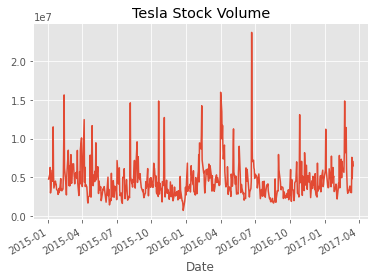

In [ ]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Tesla Stock Volume')

As seen above, the data shows the stock volume over the period of 2015-2017, however we will be selecting the variables "Date" and "Volume" as the train/test features to work on.

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6] 

In [ ]:
y

,Volume
Date,
2015-01-02,4764400
2015-01-05,5368500
2015-01-06,6261900
2015-01-07,2968400
2015-01-08,3442500
...,...
2017-03-13,3010700
2017-03-14,7575500
2017-03-15,4816600


Before we go ahead and setup the X/Y train/test groups, we will fist using a scaler to fit.transform it

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [ ]:
#first 420 for training

X_train = X_ss[:420, :]
X_test = X_ss[420:, :]

y_train = y_mm[:420, :]
y_test = y_mm[420:, :] 

And now we will print the testing and training size to see if the 80/20 ratio has been selected.

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (420, 5) (420, 1)
Testing Shape (136, 5) (136, 1)


In [ ]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

With everything in order, we will now move on to performing the first run of the LSTM model with the inputs being 5, hidden layer size being 16, and output size being 1.

In [ ]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 16
output_size = 1
num_epochs= 10

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

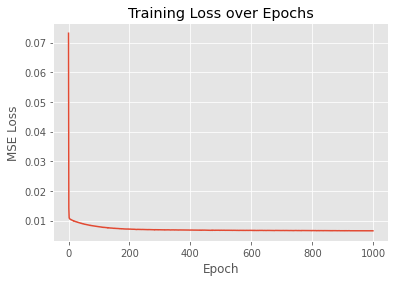

In [ ]:
# Initializing Hyperparameters
num_epochs = 1000
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        # Initialize the hidden state and the cell state
        # The hidden state and the cell state reset to zero for every epoch
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    for data, label in test_loader:
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.00702314528987687


In [ ]:
output_list = []
for i, (data, label) in enumerate(test_loader):
        
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
        
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    output_list.append(output.detach().numpy()[0][0])

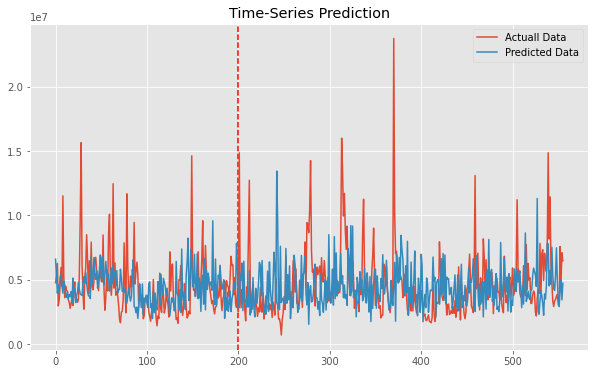

In [ ]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y.Volume.values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [ ]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

<All keys matched successfully>

The the second run of the LSTM model, we decided to set the output size to 3, and we increased the epoch size from 10, to 50, to see if it has a positive effect on the MSE score

In [ ]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 16
output_size = 3
num_epochs= 50

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


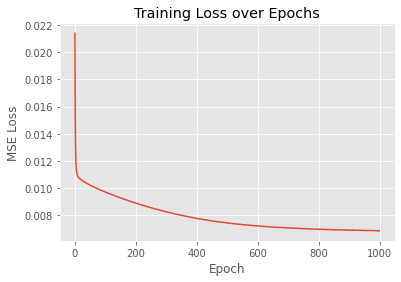

In [ ]:
# Initializing Hyperparameters
num_epochs = 1000
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        # Initialize the hidden state and the cell state
        # The hidden state and the cell state reset to zero for every epoch
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    for data, label in test_loader:
        hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.0067035122723343495


In [ ]:
output_list = []
for i, (data, label) in enumerate(test_loader):
        
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
        
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hidden = (torch.zeros(data.size(0), hidden_size),
                  torch.zeros(data.size(0), hidden_size))

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    output_list.append(output.detach().numpy()[0][0])

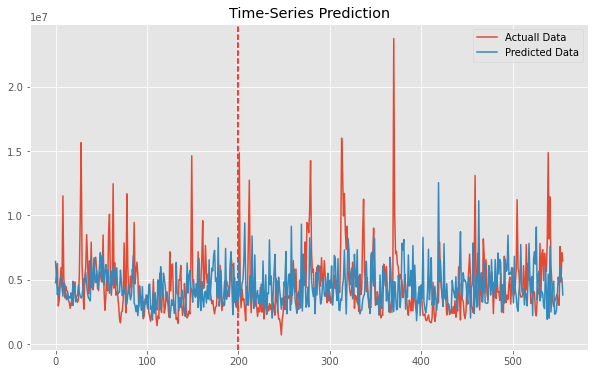

In [ ]:
# train_predict = lstm(X_ss)#forward pass
# data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = y.Volume.values
# data_predict = output_list

data_predict = mm.inverse_transform([output_list]) #reverse transformation
# dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [ ]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm.pt')

# Load the model
rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
rnn.load_state_dict(torch.load('lstm.pt'))

<All keys matched successfully>